In [20]:
# Если работаешь в Colab — можно поставить всё сразу
%pip install -q pandas numpy scikit-learn matplotlib seaborn shap

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %% [markdown]
# # Boston Housing: Linear Regression, Decision Tree, Random Forest
# Цель: сравнить качество трёх регрессионных моделей на Boston Housing.
# Метрики: MSE, MAE, R² (на тестовой выборке, 80/20).
# Автор: <ФИО>  | Дата: <дата>

# %%
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from pandas import get_option

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
IN_COLAB = "COLAB_GPU" in os.environ or "google.colab" in str(get_option())

if not IN_COLAB:
    ROOT = Path.cwd()
    if ROOT.name == "lab01":
        LAB_ROOT = ROOT
    elif (ROOT / "lab01").exists():
        LAB_ROOT = ROOT / "lab01"       # запущено из корня репо
    elif ROOT.name == "notebooks":
        LAB_ROOT = ROOT.parent          # запущено из lab01/notebooks
    else:
        raise FileNotFoundError("Не нашёл папку lab01 от текущей директории.")

    DATA_RAW = LAB_ROOT / "data" / "raw"
    DATA_RAW.mkdir(parents=True, exist_ok=True)
    csv_path = DATA_RAW / "housing.csv"

else:
    # ---- Colab ----
    from urllib.request import urlretrieve

    url = "https://raw.githubusercontent.com/OlegTertychnyi/ML-labs-Tert/main/lab01/data/raw/housing.csv"
    csv_path = Path("/content/housing.csv")

In [44]:
columns = [
    "CRIM",     # уровень преступности
    "ZN",       # доля жилых земель под застройку >25k кв. футов
    "INDUS",    # доля некоммерческих акров на город
    "CHAS",     # река Чарльз (1 — рядом, 0 — нет)
    "NOX",      # концентрация оксидов азота
    "RM",       # среднее число комнат
    "AGE",      # доля домов, построенных до 1940 г.
    "DIS",      # расстояние до деловых центров
    "RAD",      # индекс радиальных магистралей
    "TAX",      # налог на имущество
    "PTRATIO",  # соотношение учеников и учителей
    "B",        # 1000*(Bk - 0.63)^2, где Bk — доля афроамериканцев
    "LSTAT",    # % населения с низким статусом
    "MEDV"      # медианная стоимость жилья (таргет)
]
df = pd.read_csv(csv_path, sep=r"\s+", names=columns)

In [24]:
display(df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [25]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


None

In [26]:
display(df.describe())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


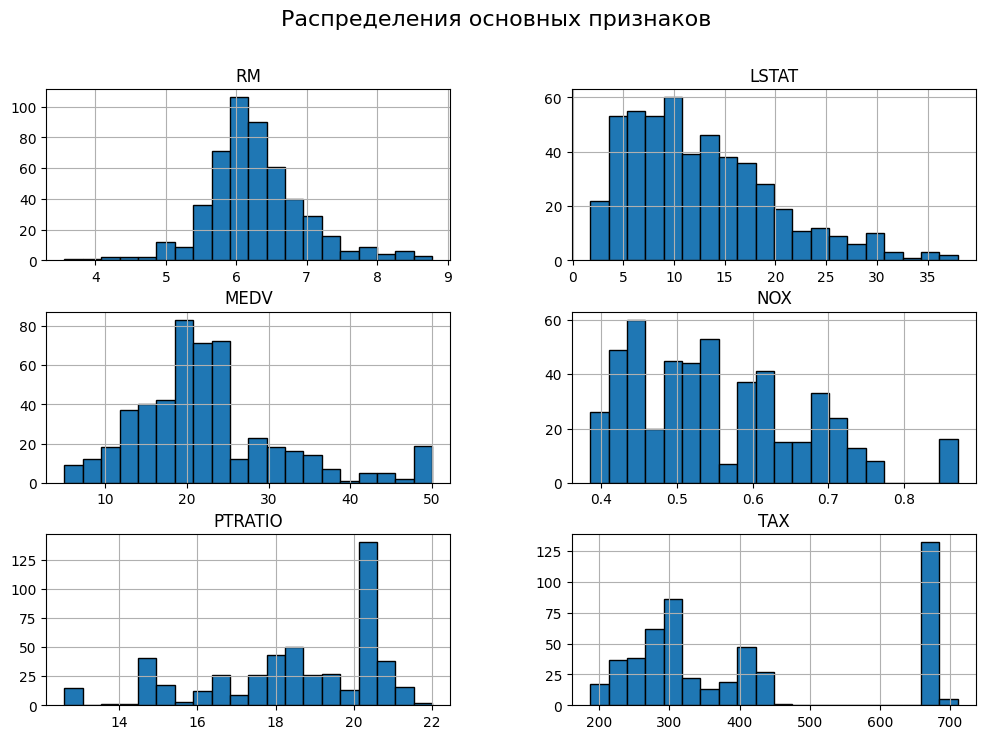

In [27]:
cols = ["RM", "LSTAT", "MEDV", "NOX", "PTRATIO", "TAX"]
df[cols].hist(bins=20, figsize=(12, 8), edgecolor='black')
plt.suptitle("Распределения основных признаков", fontsize=16)
plt.show()

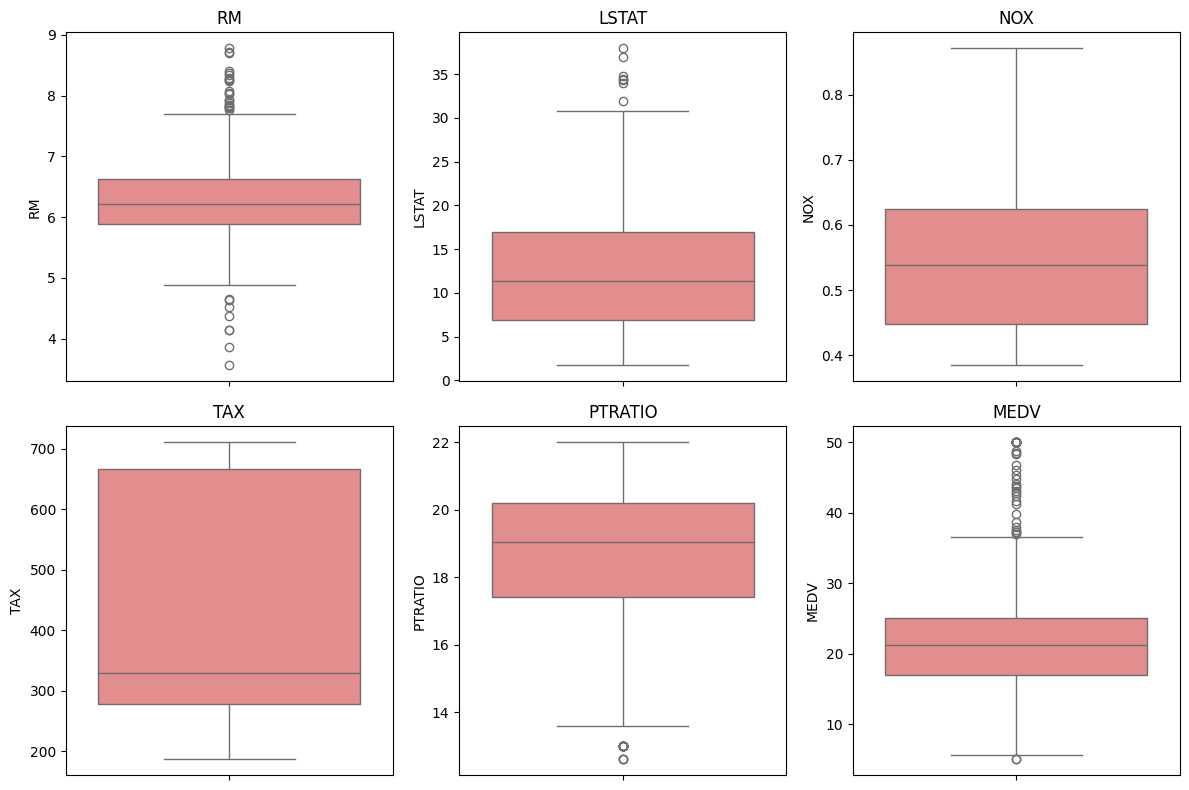

In [28]:
cols = ["RM", "LSTAT", "NOX", "TAX", "PTRATIO", "MEDV"]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, col in enumerate(cols):
    sns.boxplot(y=df[col], ax=axes[i//3, i%3], color="lightcoral")
    axes[i//3, i%3].set_title(col)

plt.tight_layout()
plt.show()


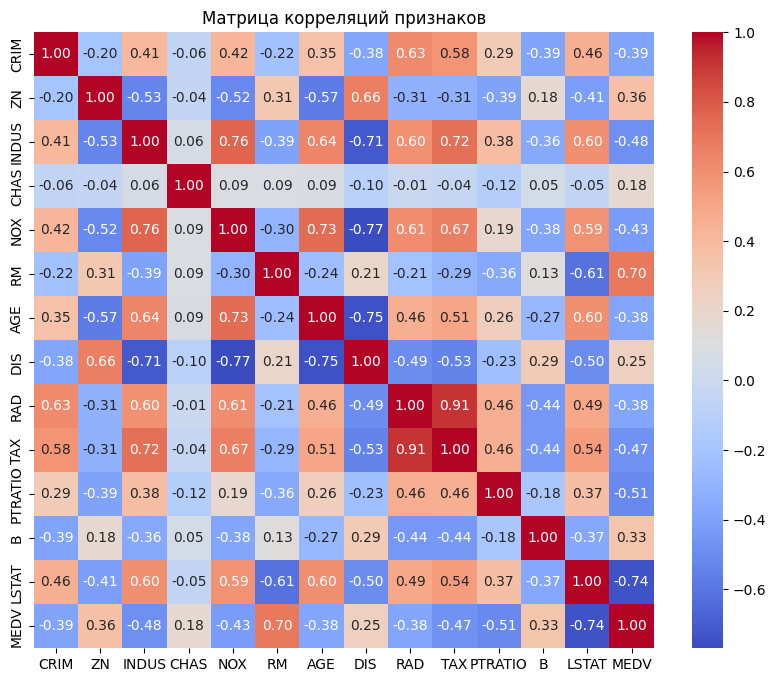

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций признаков")
plt.show()

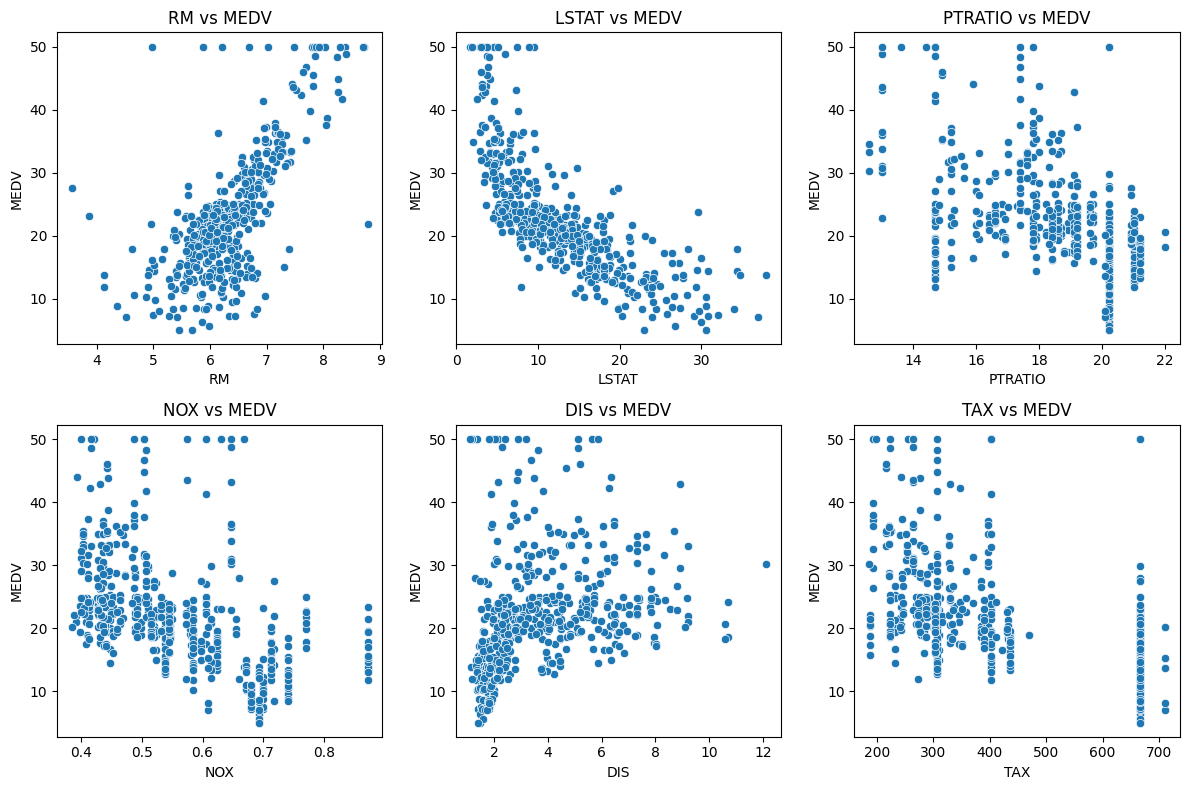

In [30]:
cols = ["RM", "LSTAT", "PTRATIO", "NOX", "DIS", "TAX"]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, col in enumerate(cols):
    sns.scatterplot(x=df[col], y=df["MEDV"], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"{col} vs MEDV")
plt.tight_layout()
plt.show()

In [31]:
X = df.drop(columns=["MEDV"])
y = df["MEDV"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
lr = Pipeline([
    ("scaler" , StandardScaler()),
    ("model", LinearRegression())
])

In [33]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = cross_val_score(lr, X_train, y_train, cv=cv, scoring="r2")
cv_mse = -cross_val_score(lr, X_train, y_train, cv=cv, scoring="neg_mean_squared_error")

display(f"CV R^2: mean = {cv_r2.mean():.3f} ± {cv_r2.std():.3f}")
display(f"CV MSE: mean = {cv_mse.mean():.3f}")

'CV R^2: mean = 0.718 ± 0.078'

'CV MSE: mean = 24.318'

In [34]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [35]:
dtr = DecisionTreeRegressor(max_depth=8, random_state=32)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

In [36]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=26)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

In [37]:
results = {}

for name, model in {
    "Linear Regression": lr,
    "Decision Tree": dtr,
    "Random Forest": rfr
}.items():
    y_pred = model.predict(X_test)
    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T
display(results_df.round(3))

,R2,MSE,MAE
Linear Regression,0.669,24.291,3.189
Decision Tree,0.900,7.300,2.045
Random Forest,0.890,8.081,2.073


/tmp/ipykernel_18341/494411334.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2", data=results_df, palette="Set2")


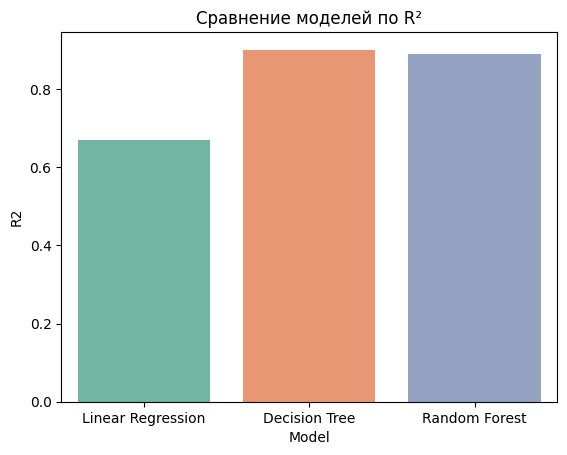

In [38]:
results_df = results_df.reset_index().rename(columns={"index": "Model"})
sns.barplot(x="Model", y="R2", data=results_df, palette="Set2")
plt.title("Сравнение моделей по R²")
plt.show()

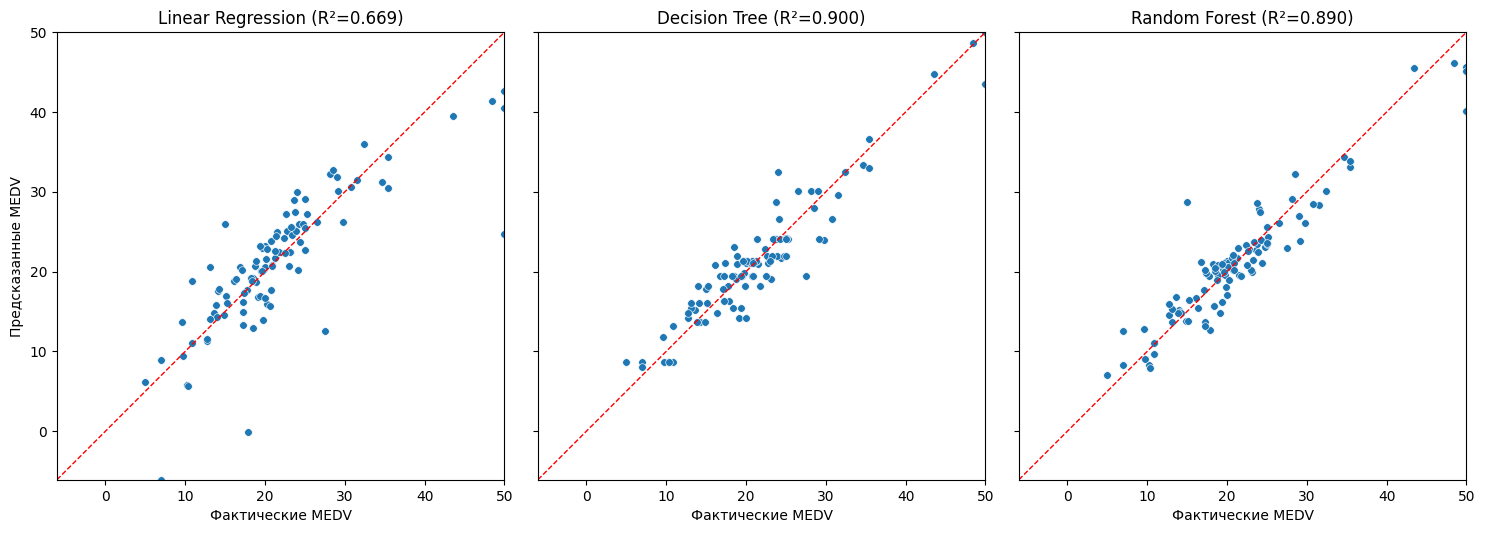

In [39]:
from sklearn.metrics import r2_score

preds = {
    "Linear Regression": lr.predict(X_test),
    "Decision Tree":     dtr.predict(X_test),
    "Random Forest":     rfr.predict(X_test),
}

# общие лимиты для наглядного сравнения
y_min = min(y_test.min(), *(p.min() for p in preds.values()))
y_max = max(y_test.max(), *(p.max() for p in preds.values()))

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, (name, y_pred) in zip(axes, preds.items()):
    sns.scatterplot(x=y_test, y=y_pred, ax=ax, s=30)
    ax.plot([y_min, y_max], [y_min, y_max], 'r--', linewidth=1)
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"{name} (R²={r2_score(y_test, y_pred):.3f})")
    ax.set_xlabel("Фактические MEDV")
    ax.set_ylabel("Предсказанные MEDV")

plt.tight_layout()
plt.show()


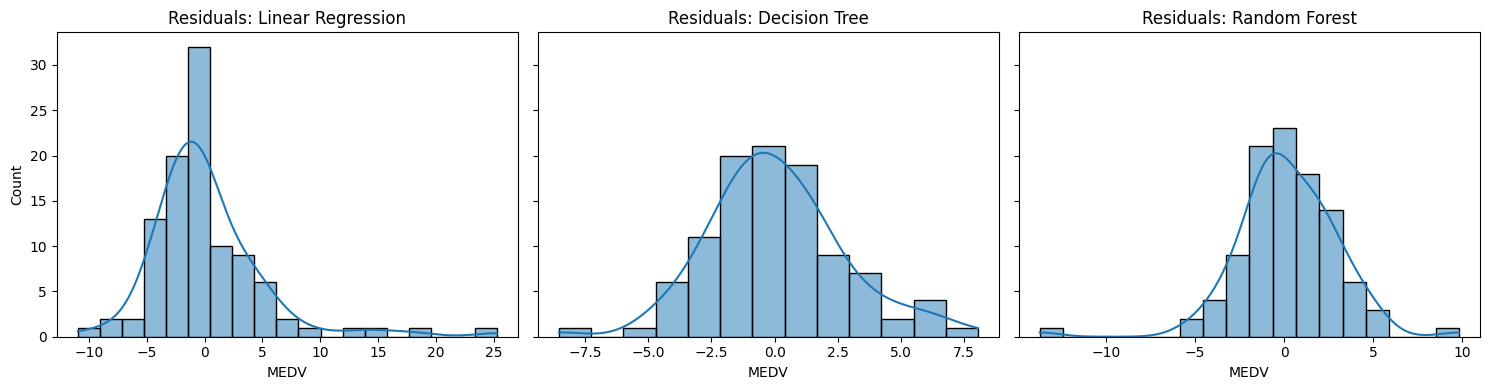

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, (name, y_pred) in zip(axes, preds.items()):
    residuals = y_test - y_pred
    sns.histplot(residuals, kde=True, ax=ax)
    ax.set_title(f"Residuals: {name}")
plt.tight_layout()
plt.show()


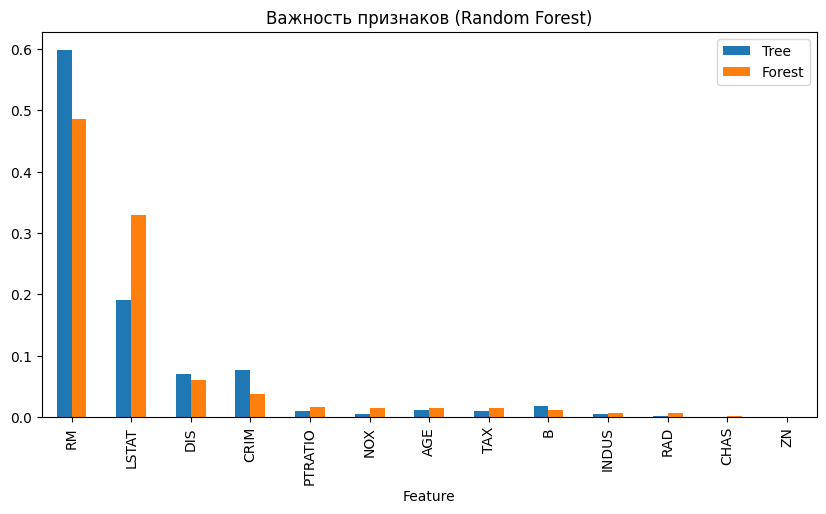

In [41]:
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Tree": dtr.feature_importances_,
    "Forest": rfr.feature_importances_
}).set_index("Feature")

feat_imp.sort_values("Forest", ascending=False).plot.bar(figsize=(10,5))
plt.title("Важность признаков (Random Forest)")
plt.show()


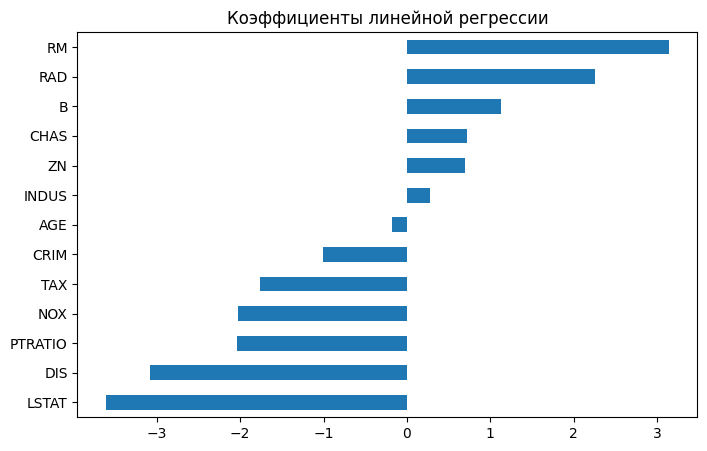

In [42]:
coefs = pd.Series(lr.named_steps["model"].coef_, index=X.columns)
coefs.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Коэффициенты линейной регрессии")
plt.show()
